# **Regression using bagging on decision trees (with more graphs)**

## **Libraries**

In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## **Decision tree regressor components**

### **Node class**

In [2]:
class Node:
    def __init__(self,
                 split_idx=None,
                 treshhold=None,
                 l_subtree=None,
                 r_subtree=None,
                 var_reduction=None,
                 leaf_node_value=None):
        self.split_idx = split_idx
        self.treshhold = treshhold
        self.l_subtree = l_subtree
        self.r_subtree = r_subtree
        self.var_reduction = var_reduction

        self.leaf_node_value = leaf_node_value

### **DT regressor**

In [3]:
class Decision_tree_regression:
    def __init__(self, n_min_samples=2, max_depth=2):
        self.n_min_samples = n_min_samples
        self.max_depth = max_depth

        self.root = None

    def fit(self, X, y):
        data = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(data)

    def build_tree(self, data, current_depth=0):
        X = data[:, :-1]
        y = data[:, -1]

        n_rows, n_columns = X.shape

        if n_rows >= self.n_min_samples and current_depth <= self.max_depth:
            best_split_values = self.get_best_split(data, n_columns)
            
            if best_split_values != {}:
                if best_split_values["var_reduction"] > 0:
                    l_subtree = self.build_tree(
                        best_split_values["l_split"], current_depth + 1
                    )
                    r_subtree = self.build_tree(
                        best_split_values["r_split"], current_depth + 1
                    )

                    return Node(
                        best_split_values["split_idx"],
                        best_split_values["treshhold"],
                        l_subtree,
                        r_subtree,
                        best_split_values["var_reduction"]
                    )

        leaf_node_value = self.calculate_leaf_node_value(y)

        return Node(leaf_node_value=leaf_node_value)

    def get_best_split(self, data, n_columns):
        max_var_reduction = -1
        best_split_values = {}

        for split_idx in range(n_columns):
            treshholds = np.unique(data[:, split_idx])

            for treshhold in treshholds:
                l_split, r_split = self.make_split(
                    data, split_idx, treshhold
                )

                if len(l_split) > 0 and len(r_split) > 0:
                    var_reduction = self.calculate_var_reduction(
                        data, l_split, r_split
                    )

                    if var_reduction > max_var_reduction:
                        best_split_values["split_idx"] = split_idx
                        best_split_values["treshhold"] = treshhold
                        best_split_values["l_split"] = l_split
                        best_split_values["r_split"] = r_split
                        best_split_values["var_reduction"] = var_reduction
                        max_var_reduction = var_reduction

        return best_split_values

    def make_split(self, data, split_idx, treshhold):
        l_split = np.array([
            row
            for row in data
            if row[split_idx] <= treshhold
        ])
        r_split = np.array([
            row
            for row in data
            if row[split_idx] > treshhold
        ])

        return l_split, r_split

    def calculate_var_reduction(self, data, l_split, r_split):
        targets = data[:, -1]
        l_split_targets = l_split[:, -1]
        r_split_targets = r_split[:, -1]

        l_split_size = len(l_split)
        r_split_size = len(r_split)
        data_size = len(targets)

        l_split_targets_var = np.var(l_split_targets)
        r_split_targets_var = np.var(r_split_targets)
        targets_var = np.var(targets)

        var = data_size * targets_var
        l_split_var = l_split_size * l_split_targets_var
        r_split_var = r_split_size * r_split_targets_var
        split_var = l_split_var + r_split_var

        var_reduction = var - split_var

        return var_reduction

    def calculate_leaf_node_value(self, targets):
        return np.mean(targets)

    def predict(self, data):
        predictions = np.array([
            self.make_prediction(x, self.root) for x in data
        ])

        return predictions.reshape(-1, 1)

    def make_prediction(self, x, node):
        if node.leaf_node_value != None:
            return node.leaf_node_value
        else:
            feature_value = x[node.split_idx]

            if feature_value <= node.treshhold:
                return self.make_prediction(x, node.l_subtree)
            else:
                return self.make_prediction(x, node.r_subtree)

## **Working with data**

In [4]:
def function(value):
    return value * np.sin(value)

In [5]:
def generate_data(n_samples=100, values_from=-10, values_to=10, noise_value=0.1):
    X = np.linspace(-10, 10, n_samples)
    X = np.sort(X)

    y = function(X) + np.random.normal(0.0, noise_value, n_samples)

    X, y = X.reshape(-1, 1), y.reshape(-1, 1)

    return X, y

In [6]:
def make_random_subset(X, y, subset_size):
    dataset = np.concatenate((X, y), axis=1)
    dataset_sub = np.array(random.sample(list(dataset), subset_size))

    return dataset_sub[:, :-1].reshape(-1, 1), dataset_sub[:, -1].reshape(-1, 1)

In [7]:
def train_decision_tree_on_random_subset(X,
                                         y,
                                         n_subset_samples=20,
                                         n_min_samples=2,
                                         max_depth=2):
    sub_X, sub_y = make_random_subset(X, y, n_subset_samples)
    model = Decision_tree_regression(n_min_samples=n_min_samples, max_depth=max_depth)
    model.fit(sub_X, sub_y)

    return model, sub_X, sub_y

In [8]:
X_from = -10
X_to = 10

X_train, y_train = generate_data(
    n_samples=100, values_from=X_from, values_to=X_to, noise_value=1.2
)
X_test, y_test = generate_data(
    n_samples=50, values_from=X_from, values_to=X_to, noise_value=1.2
)

In [9]:
true_function_X = np.linspace(X_from, X_to, 420)
true_function_y = function(true_function_X)

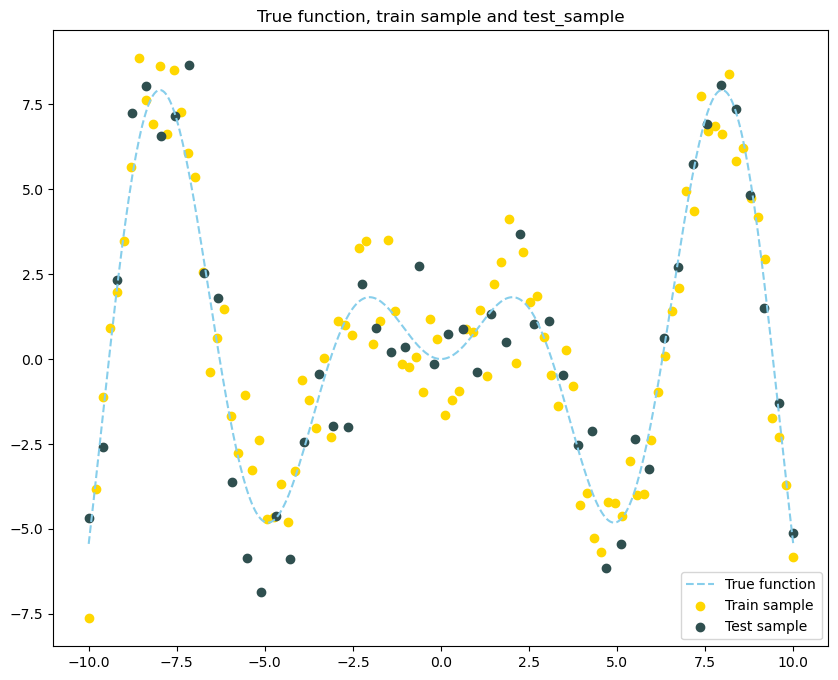

In [10]:
figure, ax = plt.subplots()

figure.set_figwidth(10)
figure.set_figheight(8)

ax.set_title("True function, train sample and test_sample")

ax.plot(
    true_function_X,
    true_function_y,
    color="skyblue",
    label="True function",
    linestyle="--"
)
ax.scatter(
    X_train, y_train, color="gold", label="Train sample"
)
ax.scatter(
    X_test, y_test, color="darkslategray", label="Test sample"
)

ax.legend()

plt.show()

## **Let's take a look at this miracle**

We train decision trees with max_deth=9 100 times on different subsets of our sample and display the result of each of the 100 trainings. We will do the same, but we will train 100 times bagging on 10 decision trees, depth 9

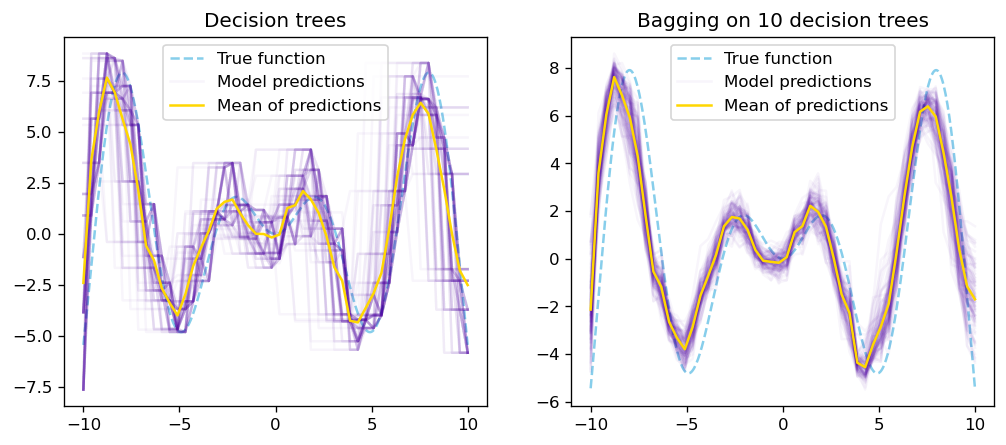

In [11]:
figure, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

# Decision trees predicts graph
ax[0].plot(
    true_function_X,
    true_function_y,
    color="skyblue",
    label="True function",
    linestyle="--"
)

predictions = []

# Decision trees training and predictions
for i in range(100):
    model, _, _ = train_decision_tree_on_random_subset(
        X_train,
        y_train,
        n_subset_samples=30,
        n_min_samples=2,
        max_depth=9
    )

    prediction = model.predict(X_test)
    predictions.append(prediction)

    if i == 0:
        ax[0].plot(
            X_test,
            prediction,
            label="Model predictions",
            color="#5002A7",
            alpha=0.04
        )
    else:
        ax[0].plot(X_test, prediction, color="#5002A7", alpha=0.04)

ax[0].plot(
    X_test,
    np.mean(np.stack(predictions), axis=0),
    color="gold",
    label="Mean of predictions"
)
ax[0].set_title("Decision trees")
ax[0].legend()

# Bagging on 10 decision trees predicts graph
ax[1].plot(
    true_function_X,
    true_function_y,
    color="skyblue",
    label="True function",
    linestyle="--"
)

predictions = []

# Bagging on 10 decision trees training and predictions
for i in range(100):
    prediction = []

    for j in range(10):
        model, _, _ = train_decision_tree_on_random_subset(
            X_train,
            y_train,
            n_subset_samples=30,
            n_min_samples=2,
            max_depth=9
        )

        prediction.append(model.predict(X_test))

    prediction = np.mean(prediction, axis=0)
    predictions.append(prediction)
    if i == 0:
        ax[1].plot(
            X_test,
            prediction,
            label="Model predictions",
            color="#5002A7",
            alpha=0.04
        )
    else:
        ax[1].plot(X_test, prediction, color="#5002A7", alpha=0.04)

ax[1].plot(
    X_test,
    np.mean(np.stack(predictions), axis=0),
    color="gold",
    label="Mean of predictions"
)
ax[1].set_title("Bagging on 10 decision trees")
ax[1].legend()

plt.show()

As we have seen, bagging is very good at reducing the variance of predictions compared to independent decision trees. However, the bias for both models is almost the same.